### Specific Test IV. Exploring Equivariant Neural Networks (Method - Self Supervised (contrastive loss) Representational Learning using Equivariant Transformers using )

#### **Name:** Yashwardhan Deshmukh [yaashwardhan@gmail.com](mailto:yaashwardhan@gmail.com)

---

**Task:** Use an Equivariant Neural Network of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.	

**Dataset:** https://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view?usp=sharing

**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

--- 

*Trained model for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1x5gm4ywOQ8brxMn11KjLBxsehQuxtx19?usp=sharing)*

**Strategy**: Equivariant Transformers are custom neural networks that ensure that the learned representations are equivariant to augmentations like rotations, where traditional networks struggle to some extent. 

Here is the strategy in detail: 
*   We can start off by implementing an Equivariant Transformer architecture that consists of a series of custom RotationalConv2D layers which are designed such that they maintain equivariance with respect to rotations of the input. Then a convolution is applied to the rotated versions of the input and combines the resulting feature maps by element-wise addition. We also use ResNet50 weights for transfer learnings to learn the representations faster.
*   For the loss function, we use contrastive loss, which encourages the model to learn embeddings that are closer for images that are similar and apart for images that are different. Basically we do -> the sum of squared distances between positive pairs (y_true = 1) and the squared hinge loss between negative pairs (y_true = 0) with a margin. 
*   Post the training of the embedding model, we finetune the model for our classification task. 



**Results:** AUC on validation set is 1

<img src="equivariant_transformers_classification_results.png" alt="(Image Load Error: Unable to load image, make sure you have downloaded the results folder)" width="700"/>


In [ ]:
!pip install tensorflow-addons
import os
import numpy as np
import tensorflow as tf
from keras import layers, models, optimizers, callbacks
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from keras.layers import BatchNormalization, ReLU, Dense, Input, GlobalAveragePooling2D, MultiHeadAttention
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import Sequence
import pandas as pd
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Reshape, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, ReLU, Input, Lambda, MultiHeadAttention, LayerNormalization, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras import layers, Model, Input
from keras.layers import Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Input, Lambda, Dense
from keras.losses import cosine_similarity

In [35]:
batch_size = 64
img_size = (150, 150)

datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")

# Data generator for classification
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
train_generator = train_datagen.flow_from_directory('lenses/lenses',target_size=img_size,batch_size=batch_size,class_mode="binary",subset="training")
validation_generator = train_datagen.flow_from_directory('lenses/lenses',target_size=img_size,batch_size=batch_size,class_mode="binary",subset="validation")
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

Found 9000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


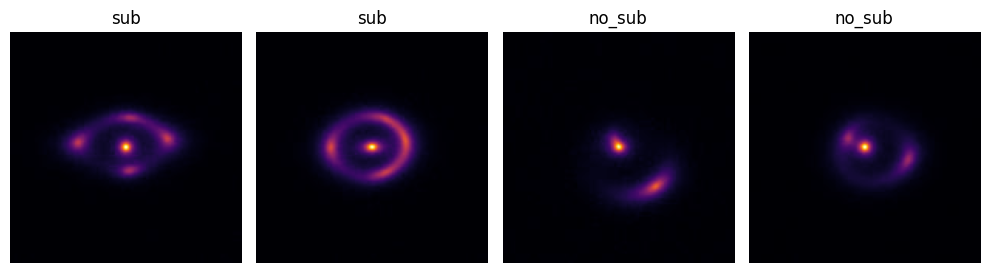

In [54]:
def plot_sample_images(train_generator, num_images_per_class=2):
    class_labels = list(train_generator.class_indices.keys())
    collected_images = []
    collected_labels = []

    while len(collected_images) < num_images_per_class * 2:
        batch_images, batch_labels = next(train_generator)

        for img, label in zip(batch_images, batch_labels):
            if int(label) == 0 and collected_labels.count(0) < num_images_per_class:
                collected_images.append(img)
                collected_labels.append(int(label))
            elif int(label) == 1 and collected_labels.count(1) < num_images_per_class:
                collected_images.append(img)
                collected_labels.append(int(label))

    fig, axes = plt.subplots(1, 4, figsize=(10, 6))
    for img, label, ax in zip(collected_images, collected_labels, axes.ravel()):
        gray_img = np.mean(img, axis=-1)
        colored_img = plt.cm.inferno(gray_img)
        ax.imshow(colored_img)
        ax.set_title(class_labels[label])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

train_generator.reset()

plot_sample_images(train_generator)

In [6]:
class RotationalConv2D(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, padding='same', **kwargs):
        super(RotationalConv2D, self).__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(num_filters, kernel_size, padding=padding)

    def call(self, inputs):
        rotated_inputs = [inputs]
        for i in range(1, 4):
            rotated_inputs.append(tf.image.rot90(inputs, i))

        conv_outputs = []
        for rotated_input in rotated_inputs:
            conv_outputs.append(self.conv(rotated_input))

        output = tf.math.add_n(conv_outputs)
        return output

In [7]:
class EquivariantTransformer(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, num_heads, **kwargs):
        super(EquivariantTransformer, self).__init__(**kwargs)
        self.conv1 = RotationalConv2D(num_filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv2 = RotationalConv2D(num_filters * 2, kernel_size, padding='same')
        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()
        self.conv3 = RotationalConv2D(num_filters * 4, kernel_size, padding='same')
        self.bn3 = BatchNormalization()
        self.relu3 = ReLU()
        self.self_attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=num_filters * 2)
        self.self_attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=num_filters * 4)
        self.pooling = GlobalAveragePooling2D()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        y = self.self_attention1(query=x, key=x, value=x)
        x = tf.add(x, y)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        y = self.self_attention2(query=x, key=x, value=x)
        x = tf.add(x, y)

        x = self.pooling(x)
        return x

In [5]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

In [26]:
input_layer = Input(shape=(150, 150, 3))
transfer_layer = tf.keras.applications.ResNet50(input_tensor=input_layer, include_top=False, weights='imagenet')
equivariant_transformer = EquivariantTransformer(num_filters=128, kernel_size=3, num_heads=3)
embedding_layer = Dense(150)

transfer_layer_output = transfer_layer.output

transformed_output = equivariant_transformer(transfer_layer_output)

embeddings = embedding_layer(transformed_output)

model = Model(inputs=input_layer, outputs=embeddings)

94765736/94765736 [==============================] - 1s 0us/step


In [27]:
model.compile(optimizer='adam', loss=contrastive_loss)

In [29]:
model.fit(train_generator,steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=10)

Epoch 1/10
125/125 [==============================] - 61s 485ms/step - loss: 0.2538 - val_loss: 0.2652
Epoch 2/10
125/125 [==============================] - 58s 463ms/step - loss: 0.2119 - val_loss: 0.2626
Epoch 3/10
125/125 [==============================] - 58s 461ms/step - loss: 0.1950 - val_loss: 0.3819
Epoch 4/10
125/125 [==============================] - 59s 471ms/step - loss: 0.1414 - val_loss: 0.4808
Epoch 5/10
125/125 [==============================] - 58s 463ms/step - loss: 0.0956 - val_loss: 0.3433
Epoch 6/10
125/125 [==============================] - 59s 470ms/step - loss: 0.0753 - val_loss: 0.3768
Epoch 7/10
125/125 [==============================] - 58s 463ms/step - loss: 0.0560 - val_loss: 0.2014
Epoch 8/10
125/125 [==============================] - 58s 462ms/step - loss: 0.0383 - val_loss: 0.5921
Epoch 9/10
125/125 [==============================] - 59s 471ms/step - loss: 0.0341 - val_loss: 0.4036
Epoch 10/10
125/125 [==============================] - 59s 472ms/step - l

In [30]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras

checkpoint = ModelCheckpoint("equivariant_transformers_checkpoint.h5", monitor='val_auc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

additional_layer = Dense(16, activation='relu')(transformed_output)
classification_model = Dense(1, activation='sigmoid')(additional_layer)
finetune_model = Model(inputs=input_layer, outputs=classification_model)
finetune_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC()])
finetune_model.fit(train_generator,steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, epochs=30, callbacks=[checkpoint, reduce_lr])


Epoch 1/30
125/125 [==============================] - 110s 513ms/step - loss: 0.1514 - auc_4: 0.9862 - val_loss: 2.1725 - val_auc_4: 0.9130 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - 58s 464ms/step - loss: 0.1604 - auc_4: 0.9844 - val_loss: 3.2930 - val_auc_4: 0.6845 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - 59s 473ms/step - loss: 0.0873 - auc_4: 0.9950 - val_loss: 0.1518 - val_auc_4: 0.9965 - lr: 0.0010
Epoch 4/30
125/125 [==============================] - 58s 464ms/step - loss: 0.0534 - auc_4: 0.9981 - val_loss: 2.3667 - val_auc_4: 0.8055 - lr: 0.0010
Epoch 5/30
125/125 [==============================] - 59s 472ms/step - loss: 0.0696 - auc_4: 0.9966 - val_loss: 0.3875 - val_auc_4: 0.9830 - lr: 0.0010
Epoch 6/30
125/125 [==============================] - 58s 464ms/step - loss: 0.1112 - auc_4: 0.9926 - val_loss: 0.6766 - val_auc_4: 0.9144 - lr: 0.0010
Epoch 7/30
125/125 [==============================] - 60s 476ms/step - loss: 0.4055 - a

In [31]:
# finetune_model.save('equivariant_transformers.h5')

In [9]:
from keras.models import load_model
loaded_model = load_model('equivariant_transformers.h5', custom_objects={'EquivariantTransformer': EquivariantTransformer}, compile=False)

In [ ]:
y_true = []
y_pred = []

for i in range(len(validation_generator)):
    X_batch, y_batch = validation_generator[i]
    y_true.extend(y_batch)
    y_pred.extend(loaded_model.predict(X_batch))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

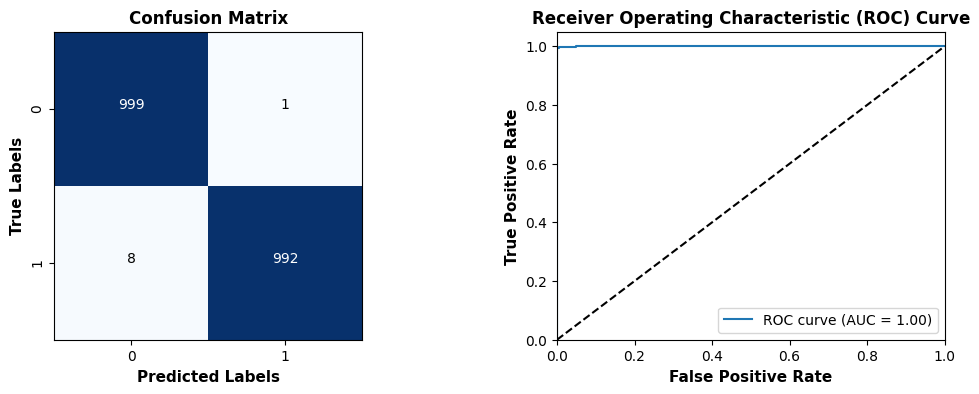

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Ensure y_true is a binary array
y_true = np.array(y_true, dtype=int)

# Binarize y_pred
y_pred_binary = np.round(y_pred)

plt.figure(figsize=(12, 4)) 

cm = confusion_matrix(y_true, y_pred_binary)
plt.subplot(121)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=11, fontweight='bold')
plt.ylabel('True Labels', fontsize=11, fontweight='bold')
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0, 1])
plt.yticks(tick_marks, [0, 1], rotation=90)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(122)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.4)
plt.show()
